In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard

from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams

LABELS = ["Normal","Fraud"]

In [2]:
#loading dataset
df = pd.read_csv('creditcard.csv')

In [3]:
#normalize variable time in [-1,1]
df['Time'] =    StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

In [4]:
#extract normal transactions
normal_df = df[df.Class == 0]

In [5]:
#extract bad transactions
fraud_df = df[df.Class == 1]

In [6]:
#Splitting data for train and test
train_x, test_x = train_test_split(normal_df, test_size=0.15,random_state=1)

In [7]:
#Remove column class
train_x = train_x.drop(['Class'], axis=1)

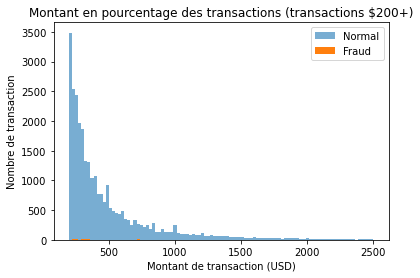

In [9]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=0.6, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=1,label='Fraud')
plt.legend(loc='upper right')
plt.title("Montant en pourcentage des transactions (transactions \$200+)")
plt.xlabel("Montant de transaction (USD)")
plt.ylabel("Nombre de transaction");
plt.show()

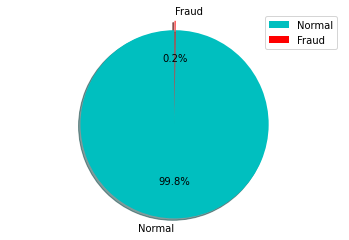

In [20]:
labels = 'Normal', 'Fraud'
sizes = [len(normal_df)/len(df), len(fraud_df)/len(df)]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

colors=['c','r']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels,colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.legend(loc='upper right')
plt.show()

In [135]:
test_x = test_x.append(fraud_df)

In [136]:
len(test_x)

43140

In [137]:
#Extract class from test data
test_y = test_x['Class']  
test_x = test_x.drop(['Class'], axis=1)

In [138]:
#Train the model
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1]
encoding_dim = 14
hidden_dim = int(encoding_dim / 1.3)
learning_rate = 1e-7

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [13]:
autoencoder.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",save_best_only=True,verbose=0)

tb = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)
history = autoencoder.fit(train_x, train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          validation_split=0.1,
                          verbose=1,
                          callbacks=[cp, tb]).history


Epoch 1/100
   1/1700 [..............................] - ETA: 0s - loss: 1725.0553 - accuracy: 0.0078WARNING:tensorflow:From /home/dimedrik/anaconda3/envs/konrad/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1700/1700 [==============================] - 2s 954us/step - loss: 2297.6257 - accuracy: 0.8292 - val_loss: 2794.6367 - val_accuracy: 0.8627
Epoch 2/100
1700/1700 [==============================] - 1s 675us/step - loss: 2229.3206 - accuracy: 0.8864 - val_loss: 2732.9895 - val_accuracy: 0.8957
Epoch 3/100
1700/1700 [==============================] - 1s 687us/step - loss: 2169.8364 - accuracy: 0.9031 - val_loss: 2676.6125 - val_accuracy: 0.9038
Epoch 4/100
1700/1700 [==============================] - 1s 669us/step - loss: 2115.2668 - accuracy: 0.9073 - val_loss: 2624.7927 - val_accuracy: 0.

Epoch 50/100
1700/1700 [==============================] - 1s 686us/step - loss: 1086.6801 - accuracy: 0.9102 - val_loss: 1609.0701 - val_accuracy: 0.9104
Epoch 51/100
1700/1700 [==============================] - 1s 825us/step - loss: 1076.3024 - accuracy: 0.9089 - val_loss: 1599.6359 - val_accuracy: 0.8903
Epoch 52/100
1700/1700 [==============================] - 1s 787us/step - loss: 1066.4082 - accuracy: 0.9093 - val_loss: 1588.4036 - val_accuracy: 0.9204
Epoch 53/100
1700/1700 [==============================] - 2s 922us/step - loss: 1056.7277 - accuracy: 0.9099 - val_loss: 1578.3561 - val_accuracy: 0.9110
Epoch 54/100
1700/1700 [==============================] - 1s 701us/step - loss: 1047.3464 - accuracy: 0.9069 - val_loss: 1569.7775 - val_accuracy: 0.8225
Epoch 55/100
1700/1700 [==============================] - 1s 742us/step - loss: 1037.8756 - accuracy: 0.9094 - val_loss: 1559.0378 - val_accuracy: 0.9119
Epoch 56/100
1700/1700 [==============================] - 1s 715us/step - lo

In [139]:
autoencoder = load_model('autoencoder_fraud.h5')

Text(0.5, 0, 'Epoch')

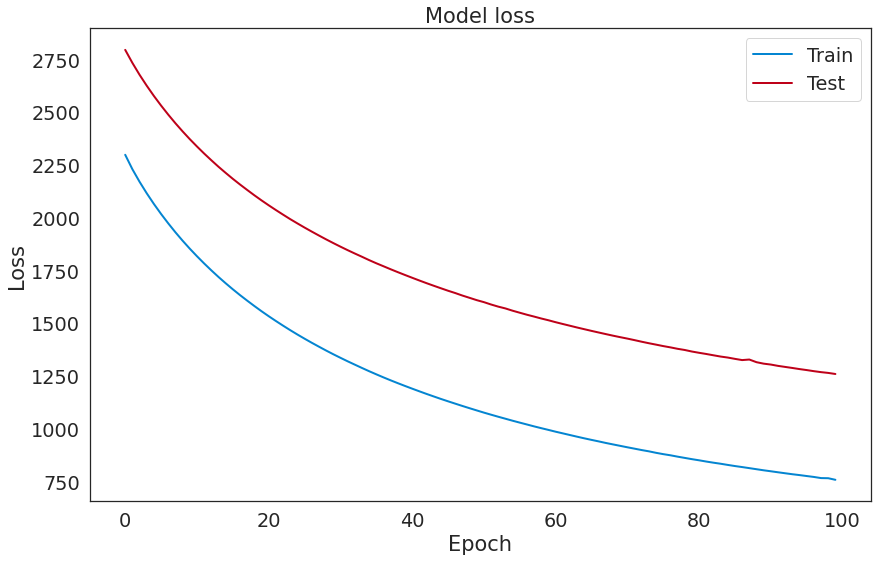

In [140]:
#Display model performance
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')

plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [141]:
#Reconstruction error check
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,4.314000e+04,43140.000000
mean,4.828794e+02,0.011405
std,1.381660e+04,0.106183
min,1.314372e-01,0.000000
25%,4.521575e-01,0.000000
50%,7.267649e-01,0.000000
75%,1.247464e+00,0.000000
max,1.455603e+06,1.000000


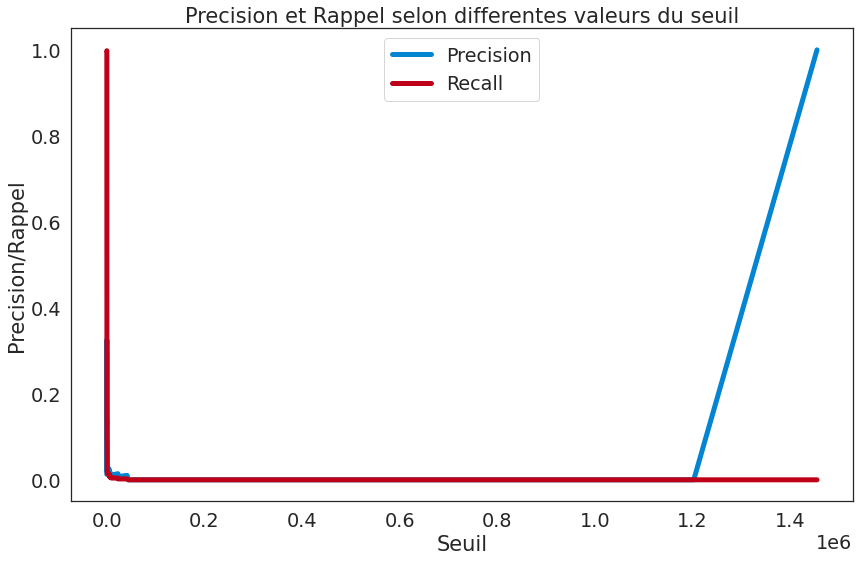

In [153]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision et Rappel selon differentes valeurs du seuil')
plt.xlabel('Seuil')
plt.ylabel('Precision/Rappel')
plt.legend()
plt.show()

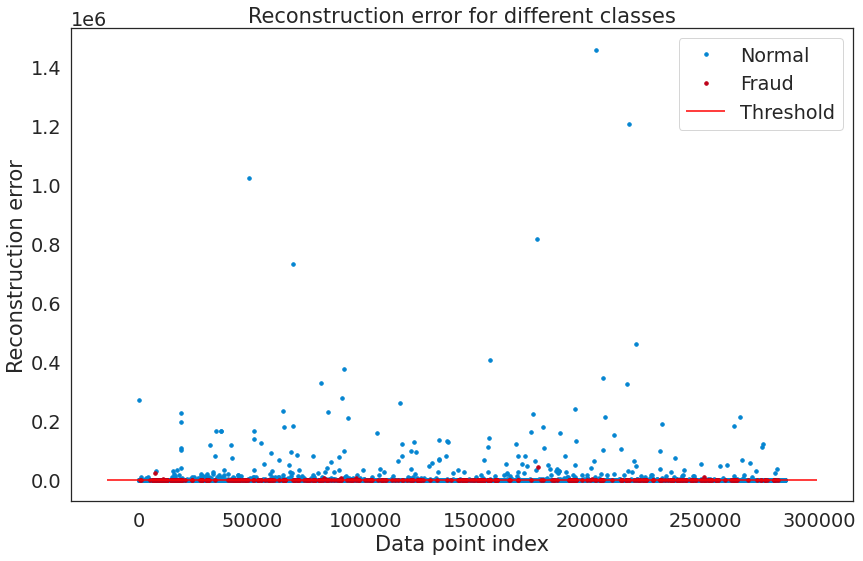

In [190]:
#Selection du seuil
threshold_fixed = 8
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show(); 

In [191]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

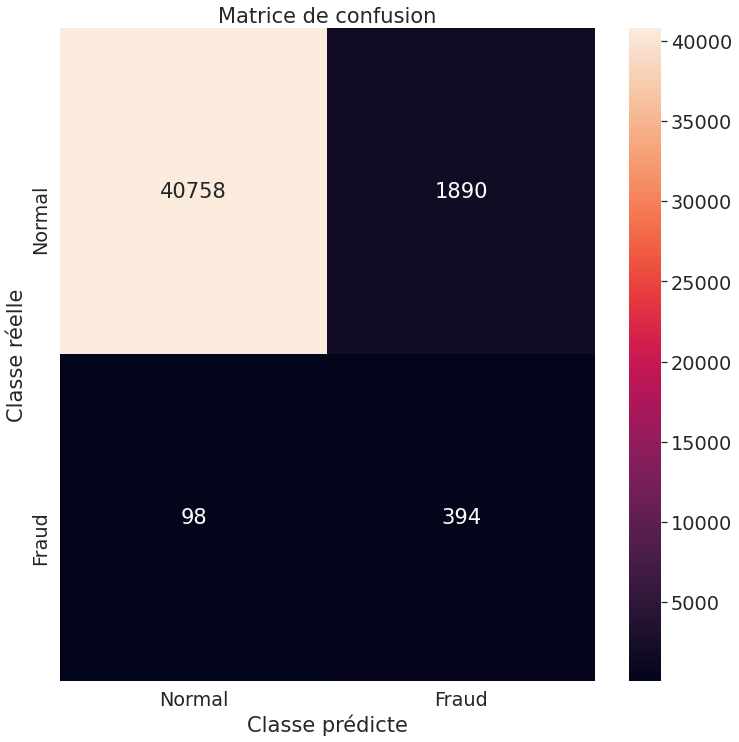

In [192]:
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Matrice de confusion")
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédicte')
plt.show()